This example conducts an analysis of the initial optwrf database in an attempt to tease out relationships among the different parameters.

Last Updated by Jeffrey Sward on June 15, 2020.

In [1]:
import csv
import datetime
import math
import random
import sys
import time

import shap
import seaborn as sns
import pandas as pd
import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def daylight(day, latitude=40):
    """
    This function calculates the number of daylight hours given jullian day of the year, and the latitude.
    For the optwrf work, I have set the default latitude to the 40th parallel since that cuts through
    the center of the domain. 
    """
    P = math.asin(0.39795 * math.cos(0.2163108 + 2 * math.atan(0.9671396 * math.tan(.00860 * (day - 186)))))
    pi = math.pi
    daylightamount = 24 - (24 / pi) * math.acos((math.sin(0.8333 * pi / 180) + 
                                                 math.sin(latitude * pi / 180) * math.sin(P)) 
                                                / (math.cos(latitude * pi / 180) * math.cos(P)))
    return daylightamount

In [3]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_database_061520.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data['fitness'].values[data['fitness'] > 6 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
# Calculate the the normalized number of daylight hours
data['j_date'] = data.start_date.apply(lambda x: x.timetuple().tm_yday)
data['day_len'] = [daylight(data.j_date.iloc[N]) for N in range(len(data.j_date))]
data['day_len_frac'] = data['day_len']/max(data['day_len'])
# Calculate the corrected fitness based upon the day length
data['fitness_corrected'] = data.fitness/data.day_len_frac
data.iloc[:5,:]


The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime,season,j_date,day_len,day_len_frac,fitness_corrected
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00,winter,363,9.346323,0.622404,NaN
1,2011-11-27,13,5,7,5,5,14,1,2034.42319,4:39:34.359051,fall,331,9.660898,0.643353,3162.219899
2,2011-09-01,14,4,7,1,1,11,2,NaN,0:00:00.042498,fall,244,13.118862,0.873631,NaN
3,2011-04-06,18,1,5,7,9,16,1,NaN,6:00:01.733799,spring,96,12.838070,0.854932,NaN
4,2011-05-02,14,7,1,7,8,94,1,NaN,6:00:06.829933,spring,122,13.904221,0.925930,NaN


## Random Forest Model

In this section, I train a random forest regression model to compare the relative feature importances. 

In [4]:
# Drop the start_date variable to train the random forest regressor
RFfeatures = data[['mp_physics', 'ra_lw_physics', 'ra_sw_physics', 
                  'sf_surface_physics', 'bl_pbl_physics', 'cu_physics', 
                  'fitness', 'fitness_corrected']]

# Drop rows where there are NaN values
RFfeatures = RFfeatures.dropna()

# Convert param_ids back to names so the RF algorithm will recognize them as separe categories
RFfeatures['mp_physics'] = num2name(RFfeatures.mp_physics, 'microphysics')
RFfeatures['ra_lw_physics'] = num2name(RFfeatures.ra_lw_physics, 'lw radiation')
RFfeatures['ra_sw_physics'] = num2name(RFfeatures.ra_sw_physics, 'sw radiation')
RFfeatures['sf_surface_physics'] = num2name(RFfeatures.sf_surface_physics, 'land surface')
RFfeatures['bl_pbl_physics'] = num2name(RFfeatures.bl_pbl_physics, 'PBL')
RFfeatures['cu_physics'] = num2name(RFfeatures.cu_physics, 'cumulus')
RFfeatures.iloc[:5,:]

,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,fitness,fitness_corrected
1,sbu-ylin,new goddard,flg,clm4,mynn2,ysu gfs sas,2034.423190,3162.219899
5,wsm6,held-suarez,dudia,pleim-xiu,mynn2,bmj,1363.634615,2189.119078
6,goddard,held-suarez,flg,5 layer,temf,ysu gfs sas,1211.080139,1709.101376
7,nssl 1mom no hail,cam,rrtmg fast,noah,acm2,grell-freitas,770.247851,1100.724772
8,p3 2mom,rrtmg fast,cam,noah-mp,mynn2,new tiedtke,807.914899,985.336759


In [5]:
# One-hot encode the data using pandas get_dummies
RFfeatures = pd.get_dummies(RFfeatures)
RFfeatures.iloc[:5,:]

,fitness,fitness_corrected,mp_physics_cam5.1,mp_physics_eta,mp_physics_goddard,mp_physics_kressler,mp_physics_lin,mp_physics_milbrandt2mom,mp_physics_morrison2mom,mp_physics_nssl 1mom,...,cu_physics_grell3d,cu_physics_hwrf gfs sas,cu_physics_kain-fritsch,cu_physics_mod kain-fritsch,cu_physics_multi kain-fritsch,cu_physics_new tiedtke,cu_physics_old kain-fritsch,cu_physics_tiedtke,cu_physics_ysu gfs sas,cu_physics_zhang-mcfarlane
1,2034.423190,3162.219899,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1363.634615,2189.119078,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1211.080139,1709.101376,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,770.247851,1100.724772,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,807.914899,985.336759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# Labels are the values we want to predict
labels = RFfeatures['fitness']
labels_corrected = RFfeatures['fitness_corrected']

# Remove the labels from the features
RFfeatures = RFfeatures.drop(['fitness', 'fitness_corrected'], axis = 1)
feature_names = list(RFfeatures.columns)

# Train the Random Forest Regressor model
model = RandomForestRegressor()
# model.fit(RFfeatures, labels)
model.fit(RFfeatures, labels_corrected)
# print(model.feature_importances_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

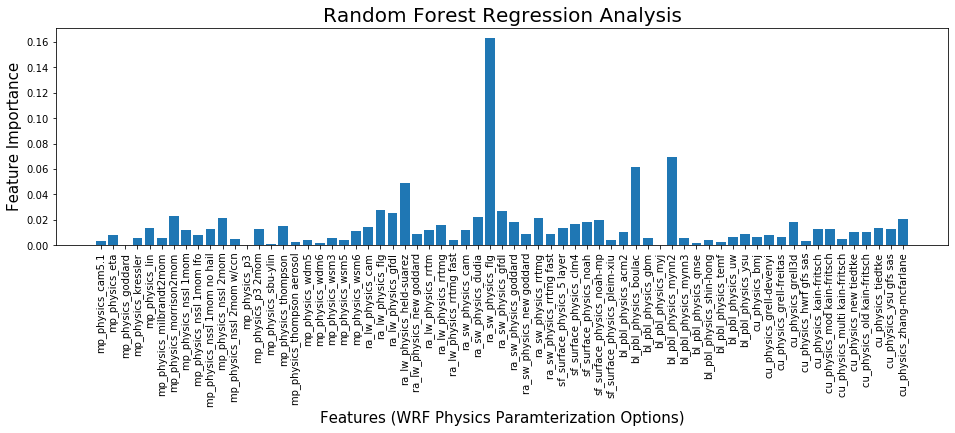

In [7]:
# Plot the RF model feature importances
fig, ax = plt.subplots(figsize=(16, 4))
ax.bar(feature_names, model.feature_importances_)
ax.set_xlabel('Features (WRF Physics Paramterization Options)', fontsize = 15)
ax.set_ylabel('Feature Importance', fontsize = 15)
ax.set_title('Random Forest Regression Analysis', fontsize = 20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    tick.label.set_rotation('vertical')

# SHAP TreeExplainer

SHAP values represent a feature's contribution to a change in the model ouput. In contrast to the feature importances shown above which give a relative importance and are therefore comparative, SHAP values reveal if each feature pushes model output higher or lower, so therefore can be summed -- revealing the contribution that a group of features have on model output as well. 

In [8]:
# load JS visualization code to notebook
shap.initjs()

In [9]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(RFfeatures)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [10]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[2,:], RFfeatures.iloc[2,:])

## Summary Plots

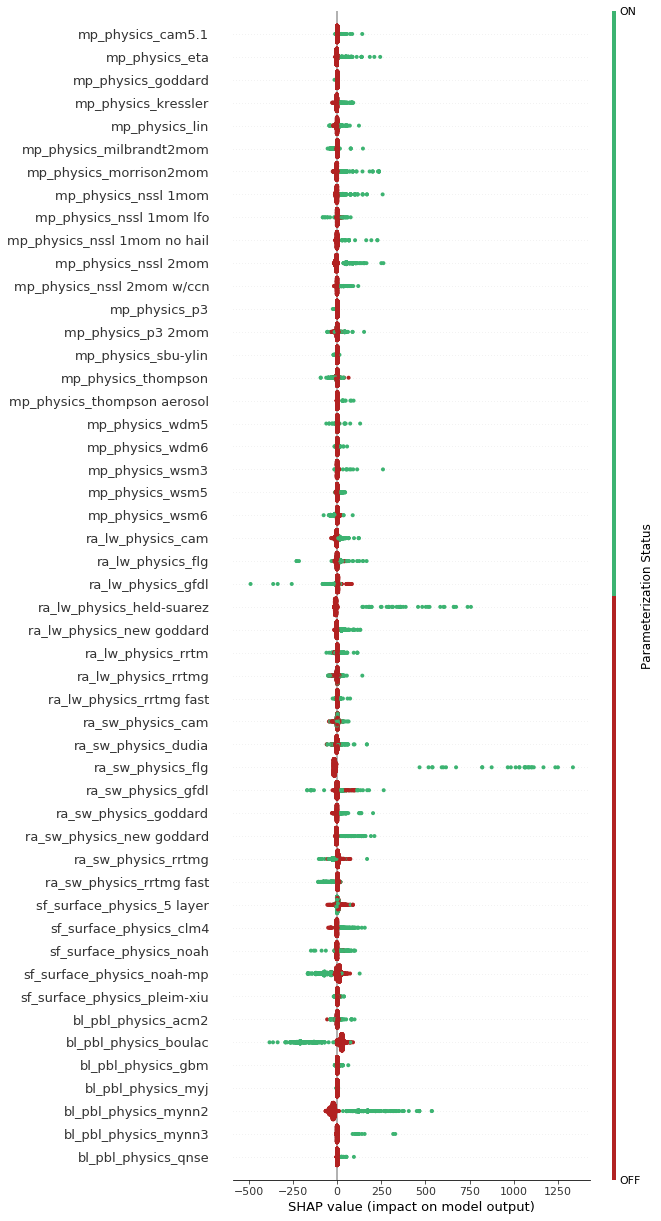

<Figure size 432x288 with 0 Axes>

In [11]:
# summarize the effects of all the features
# NOTE: there are only two options for each feature value (1: physics scheme used; 0: physics schemem not used)
# meaning that all red dots correspond to a package being used whereas blue dots correspond to a package NOT being 
# used. Therefore, this plot can be interpreted as: red values on the left are those that push model fitness (error)
# lower, and red values on the right increase model error. The further to the right the dots fall, 
# the higher the error the use of this physics package causes. 

shap.summary_plot(shap_values, RFfeatures, max_display=50, color_bar_label='Parameterization Status', sort=False)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Shap_summary.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [ ]:
shap.summary_plot(shap_values, RFfeatures, plot_type="bar")

## Microphysics Schemes Dependence Plots

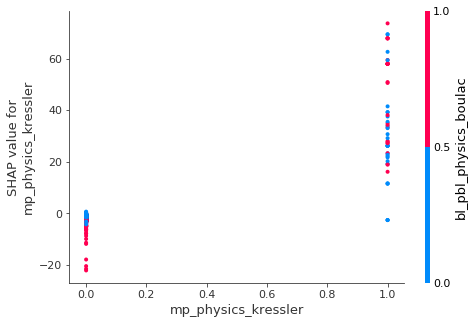

In [12]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_kressler', shap_values, RFfeatures)

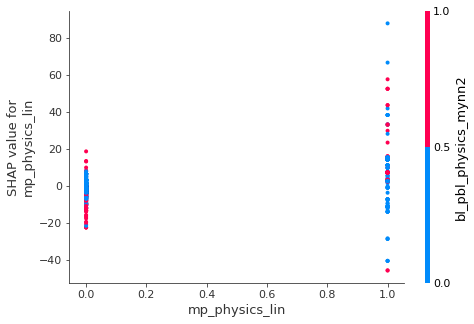

In [13]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_lin', shap_values, RFfeatures)

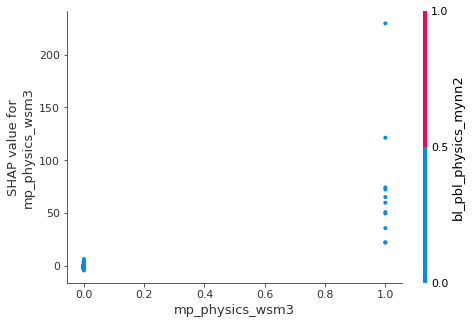

In [14]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_wsm3', shap_values, RFfeatures)

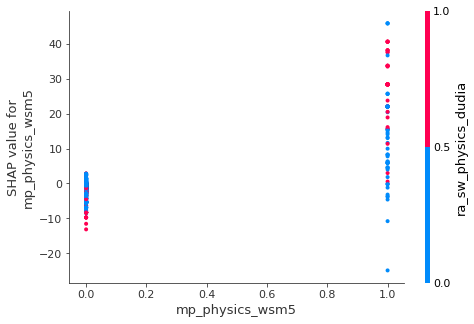

In [15]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_wsm5', shap_values, RFfeatures)

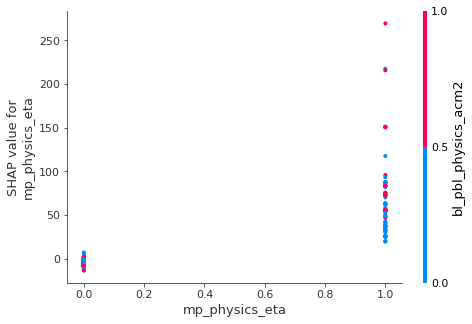

In [16]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_eta', shap_values, RFfeatures)

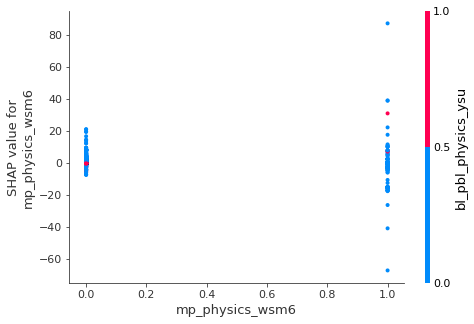

In [17]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_wsm6', shap_values, RFfeatures)

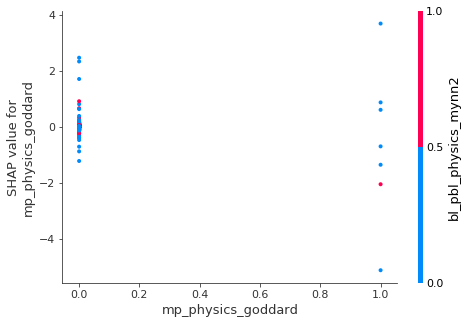

In [18]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_goddard', shap_values, RFfeatures)

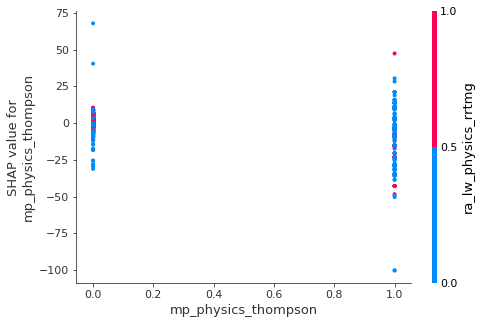

In [19]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_thompson', shap_values, RFfeatures)

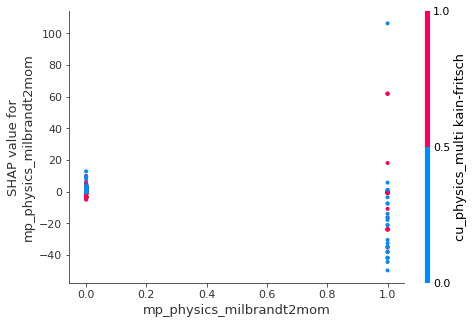

In [20]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_milbrandt2mom', shap_values, RFfeatures)

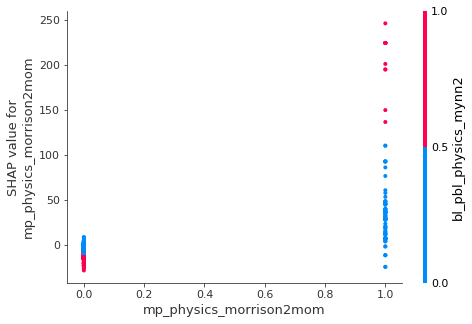

In [21]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_morrison2mom', shap_values, RFfeatures)

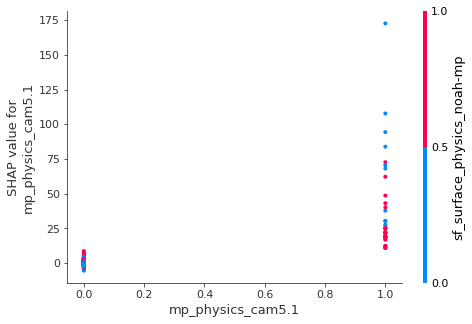

In [22]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_cam5.1', shap_values, RFfeatures)

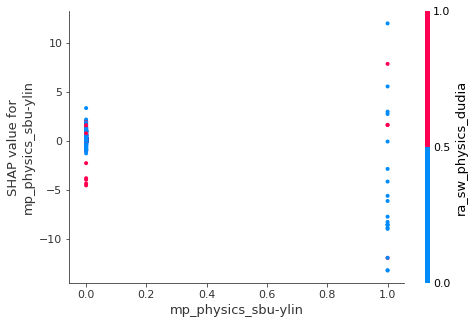

In [23]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_sbu-ylin', shap_values, RFfeatures)

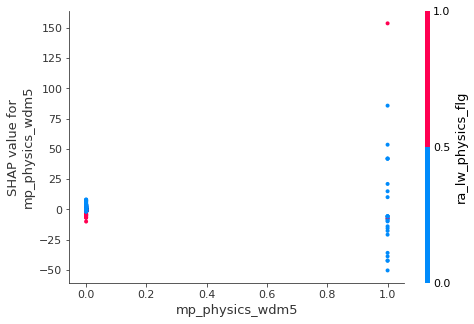

In [24]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_wdm5', shap_values, RFfeatures)

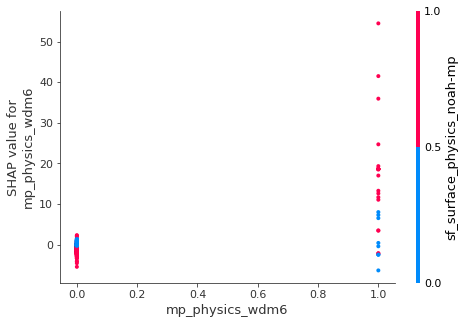

In [25]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_wdm6', shap_values, RFfeatures)

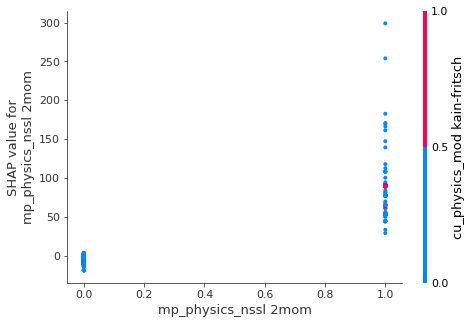

In [26]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_nssl 2mom', shap_values, RFfeatures)

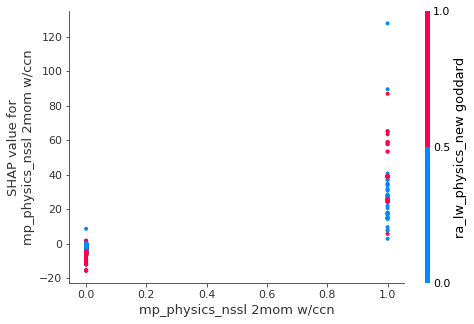

In [27]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_nssl 2mom w/ccn', shap_values, RFfeatures)

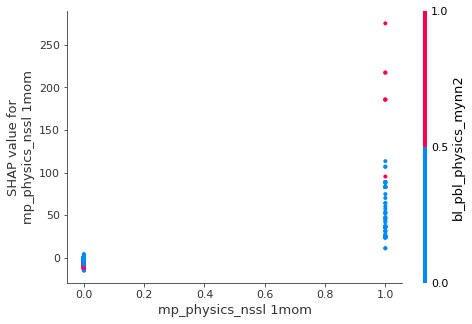

In [28]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_nssl 1mom', shap_values, RFfeatures)

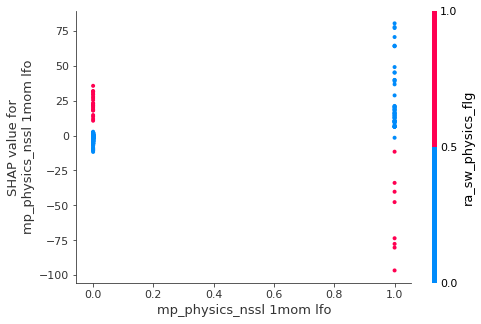

In [29]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_nssl 1mom lfo', shap_values, RFfeatures)

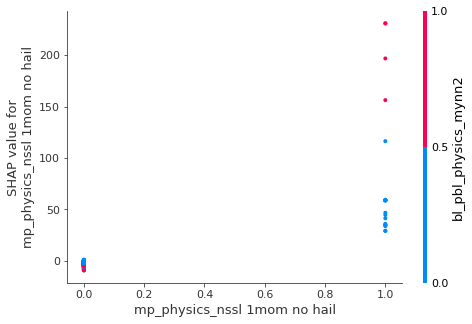

In [30]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_nssl 1mom no hail', shap_values, RFfeatures)

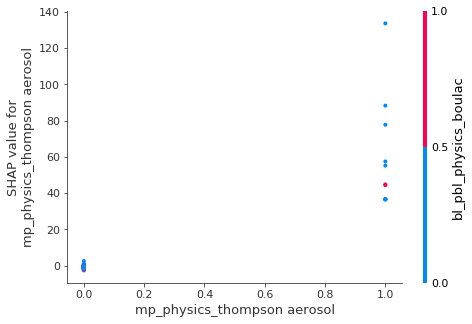

In [31]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_thompson aerosol', shap_values, RFfeatures)

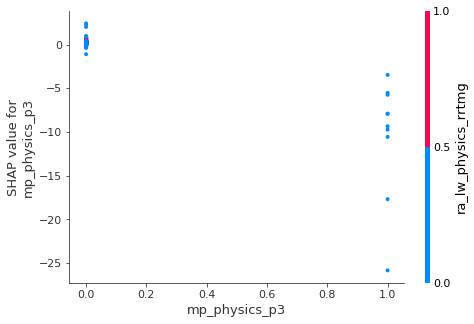

In [32]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_p3', shap_values, RFfeatures)

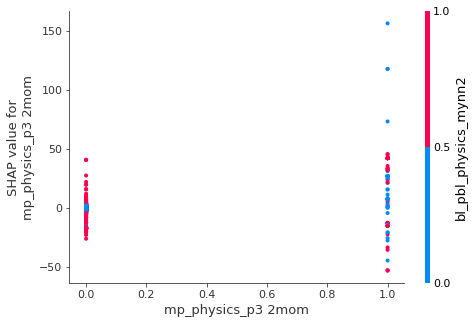

In [33]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('mp_physics_p3 2mom', shap_values, RFfeatures)

# Shortwave Physics Dependence Plots

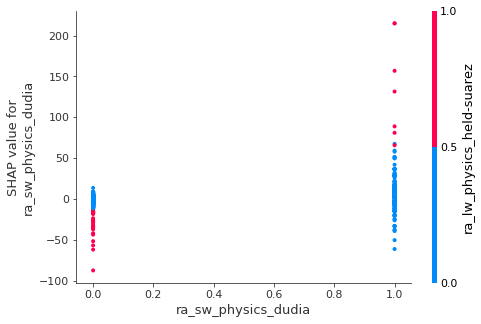

In [34]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_sw_physics_dudia', shap_values, RFfeatures)

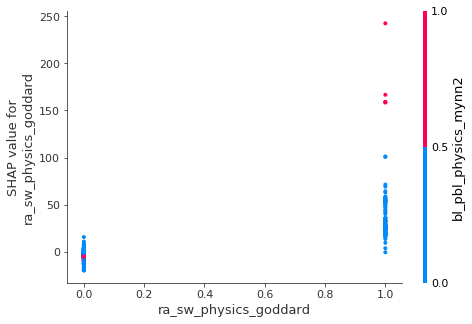

In [35]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_sw_physics_goddard', shap_values, RFfeatures)

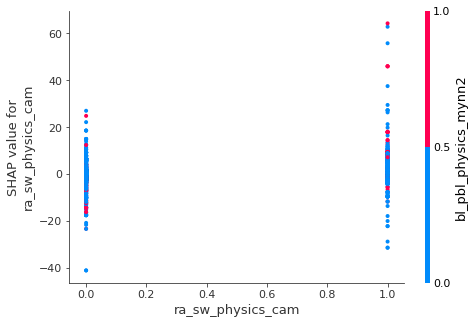

In [36]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_sw_physics_cam', shap_values, RFfeatures)

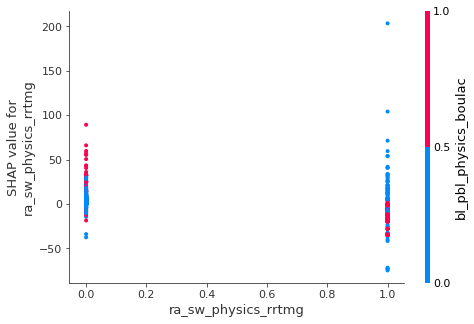

In [37]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_sw_physics_rrtmg', shap_values, RFfeatures)

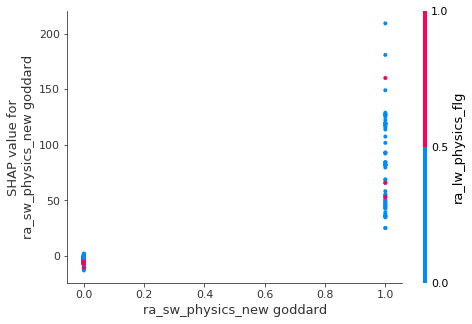

In [38]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_sw_physics_new goddard', shap_values, RFfeatures)

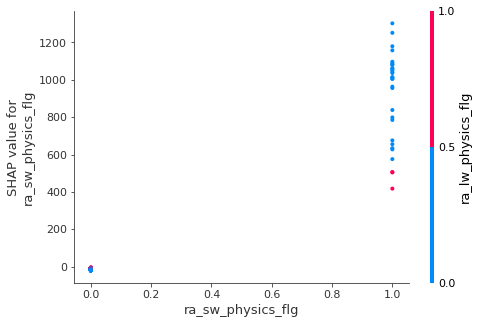

In [39]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_sw_physics_flg', shap_values, RFfeatures)

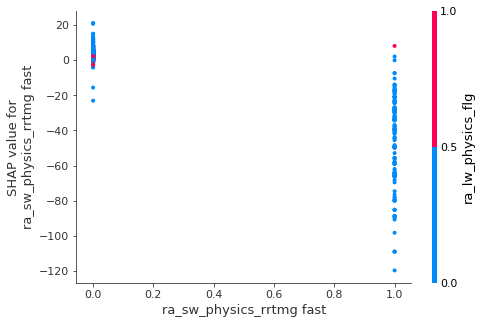

In [40]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_sw_physics_rrtmg fast', shap_values, RFfeatures)

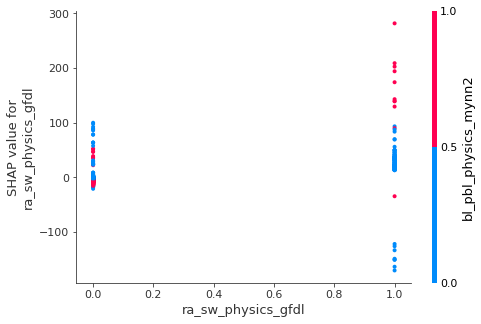

In [41]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_sw_physics_gfdl', shap_values, RFfeatures)

# Longwave Physics Dependence Plots

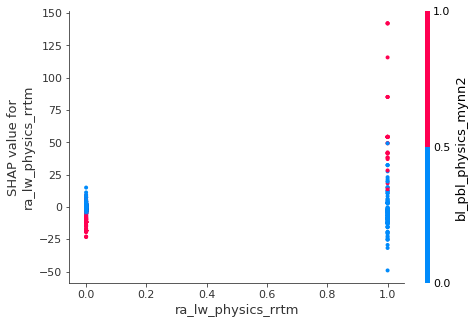

In [42]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_lw_physics_rrtm', shap_values, RFfeatures)

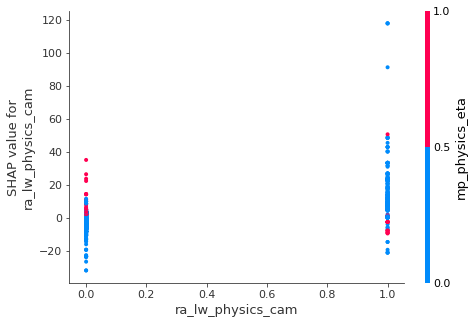

In [43]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_lw_physics_cam', shap_values, RFfeatures)

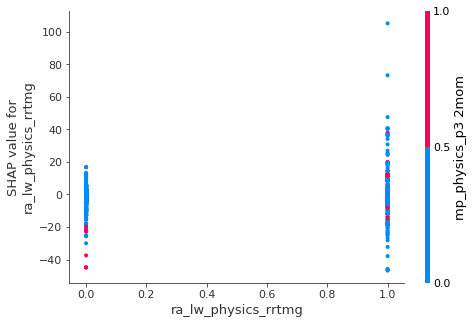

In [44]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_lw_physics_rrtmg', shap_values, RFfeatures)

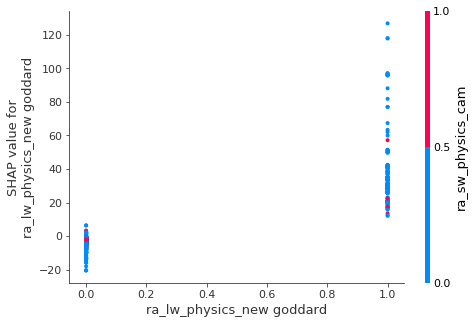

In [45]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_lw_physics_new goddard', shap_values, RFfeatures)

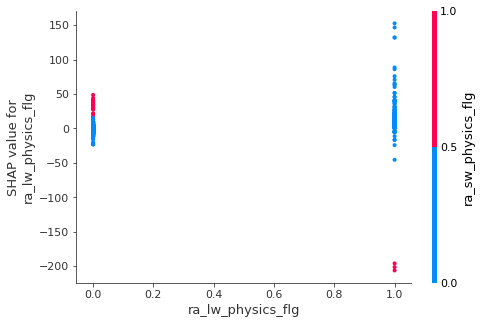

In [46]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_lw_physics_flg', shap_values, RFfeatures)

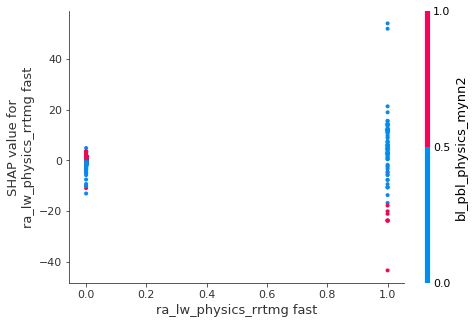

In [47]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_lw_physics_rrtmg fast', shap_values, RFfeatures)

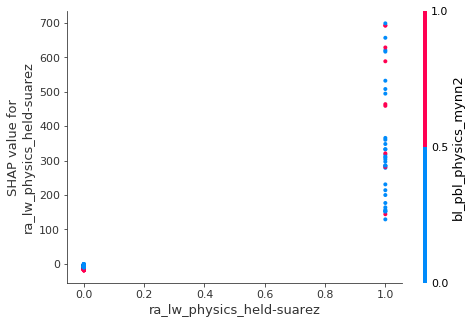

In [49]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_lw_physics_held-suarez', shap_values, RFfeatures)

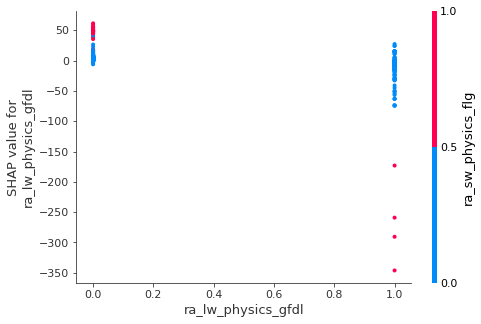

In [50]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ra_lw_physics_gfdl', shap_values, RFfeatures)

# Land Surface Dependence Plots

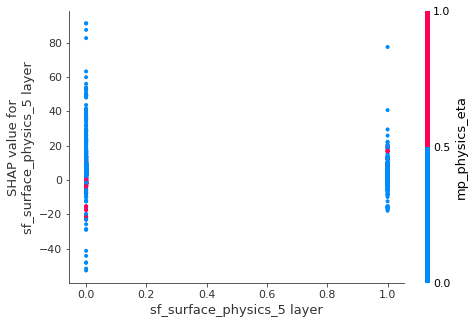

In [51]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('sf_surface_physics_5 layer', shap_values, RFfeatures)

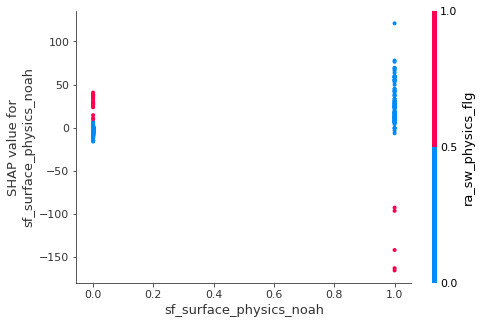

In [52]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('sf_surface_physics_noah', shap_values, RFfeatures)

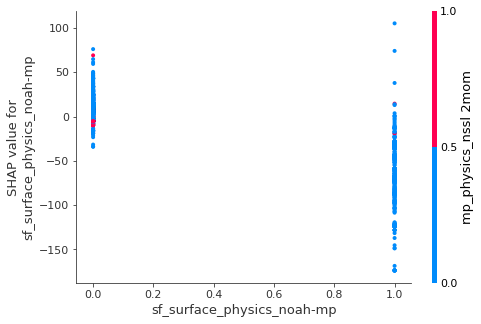

In [53]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('sf_surface_physics_noah-mp', shap_values, RFfeatures)

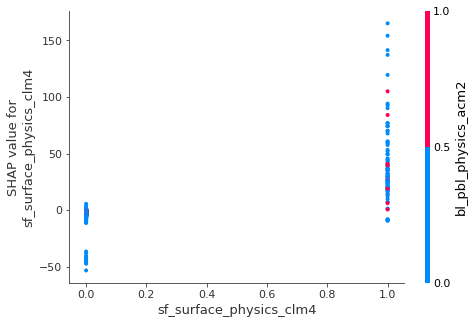

In [54]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('sf_surface_physics_clm4', shap_values, RFfeatures)

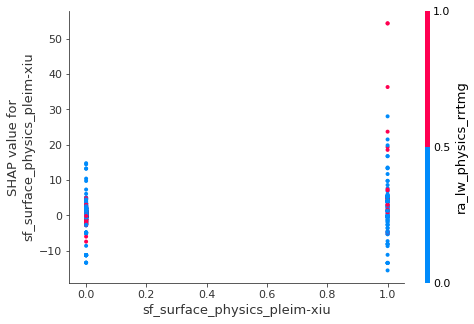

In [55]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('sf_surface_physics_pleim-xiu', shap_values, RFfeatures)

# PBL Physics Dependence Plots

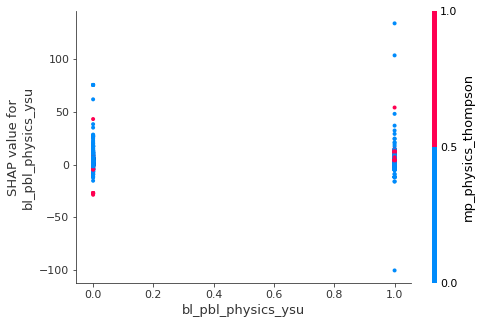

In [56]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_ysu', shap_values, RFfeatures)

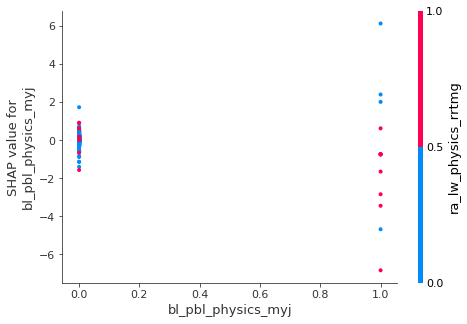

In [57]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_myj', shap_values, RFfeatures)

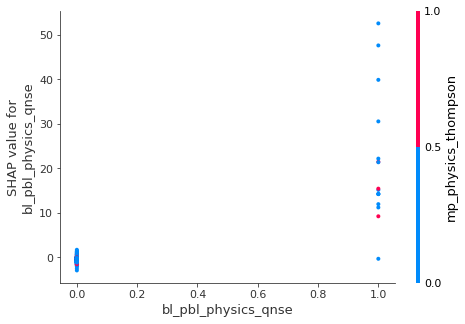

In [58]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_qnse', shap_values, RFfeatures)

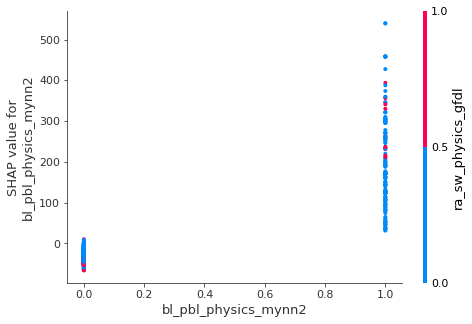

In [59]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_mynn2', shap_values, RFfeatures)

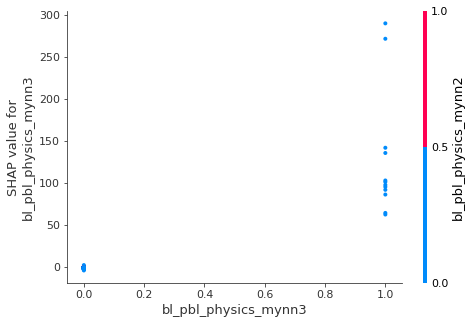

In [60]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_mynn3', shap_values, RFfeatures)

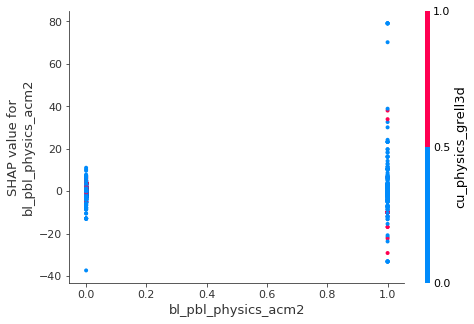

In [61]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_acm2', shap_values, RFfeatures)

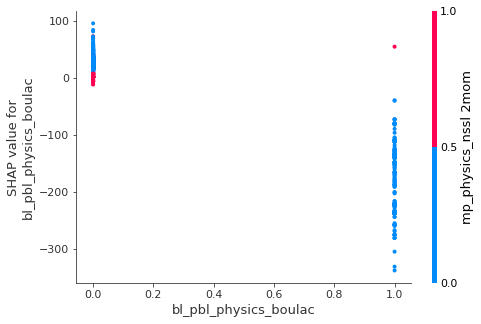

In [62]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_boulac', shap_values, RFfeatures)

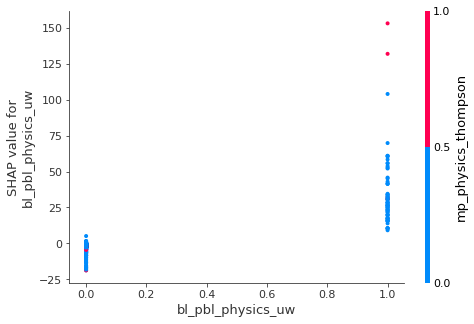

In [63]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_uw', shap_values, RFfeatures)

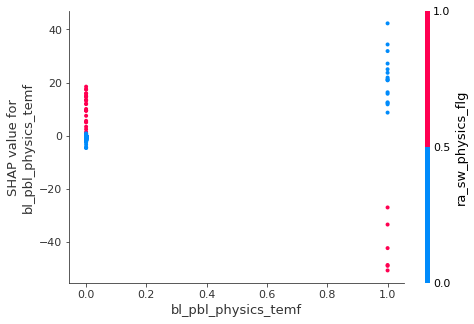

In [64]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_temf', shap_values, RFfeatures)

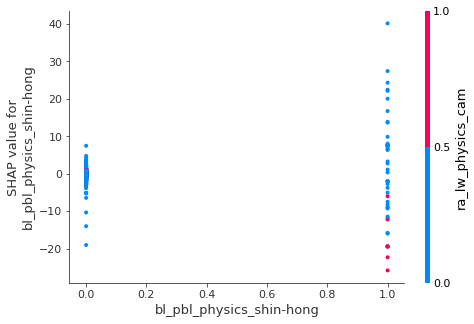

In [65]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_shin-hong', shap_values, RFfeatures)

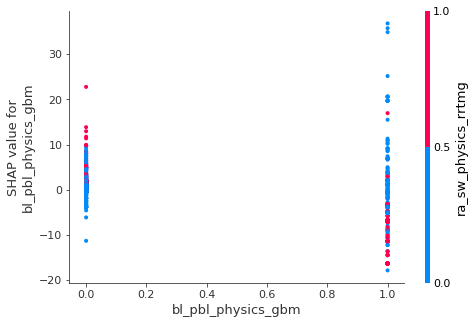

In [66]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('bl_pbl_physics_gbm', shap_values, RFfeatures)

# Cumulus Physics Dependence Plots

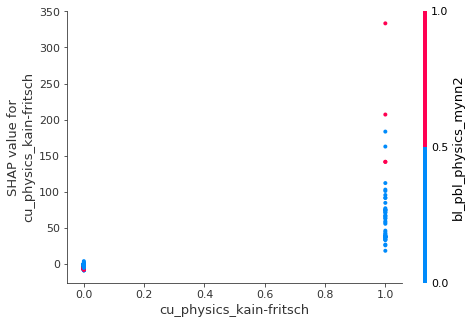

In [67]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_kain-fritsch', shap_values, RFfeatures)

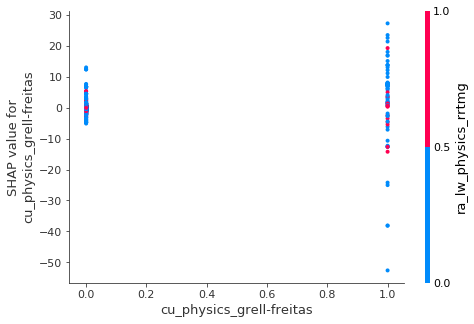

In [69]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_grell-freitas', shap_values, RFfeatures)

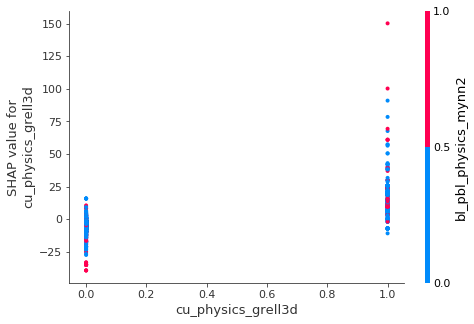

In [70]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_grell3d', shap_values, RFfeatures)

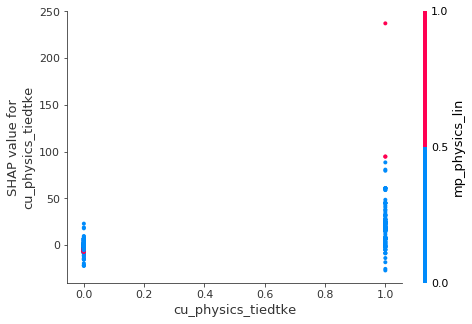

In [71]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_tiedtke', shap_values, RFfeatures)

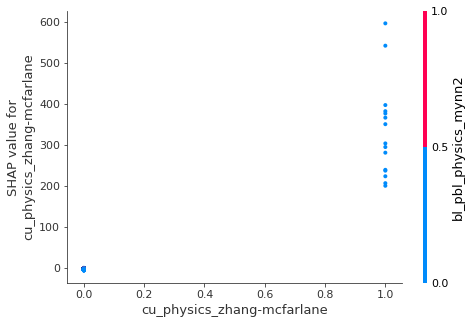

In [72]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_zhang-mcfarlane', shap_values, RFfeatures)

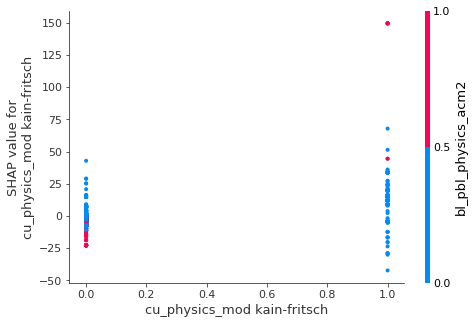

In [73]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_mod kain-fritsch', shap_values, RFfeatures)

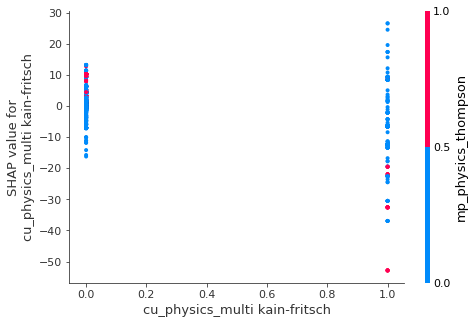

In [74]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_multi kain-fritsch', shap_values, RFfeatures)

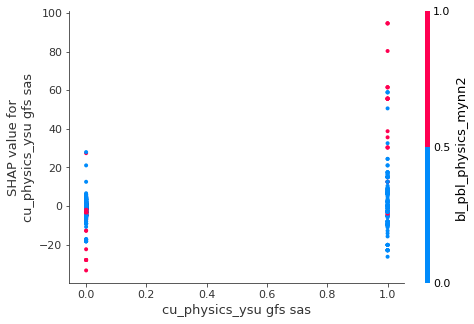

In [75]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_ysu gfs sas', shap_values, RFfeatures)

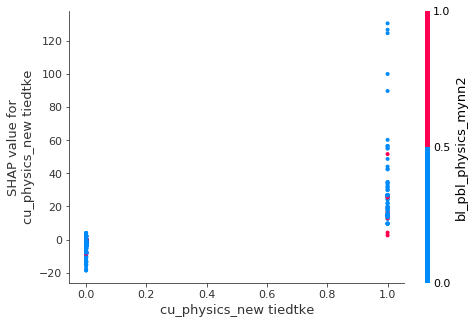

In [76]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_new tiedtke', shap_values, RFfeatures)

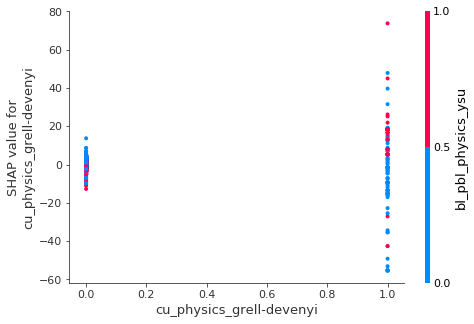

In [77]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_grell-devenyi', shap_values, RFfeatures)

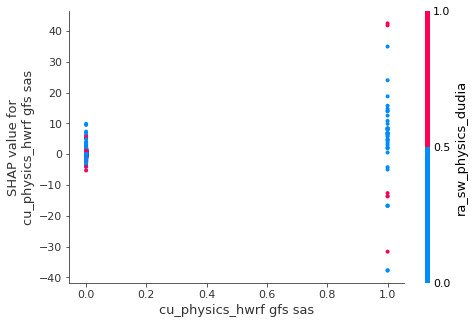

In [78]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_hwrf gfs sas', shap_values, RFfeatures)

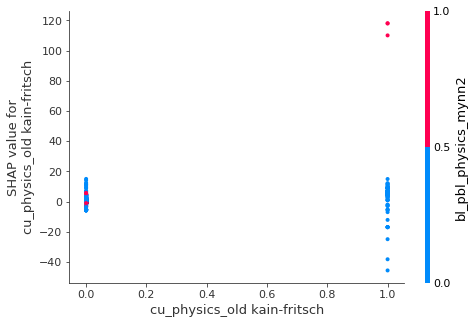

In [79]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('cu_physics_old kain-fritsch', shap_values, RFfeatures)